In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from math import ceil

def to_delta(df, column):
    start = df[column].min()
    df[column] = df[column].apply(lambda dt: dt - start)
    df.set_index(column, inplace=True, drop=False)

def load_cloudwatch(filename):
    logs = pd.read_csv(filename)
    logs = logs.sort_values(by='timestamp')
    logs['timestamp'] = pd.to_datetime(logs['timestamp'])
    to_delta(logs, 'timestamp')
    return logs

def start_plot():
    fig, ax = plt.subplots()
    ax.set_xlabel("Czas trwania testu [h]")

    return (fig, ax)

def human_delta(index):
    return index.get_level_values('timestamp').seconds / 60 / 60

In [28]:
prefix = 'serverless_v4_raw_data/'
filename = f"{prefix}/logs.csv"

logs = load_cloudwatch(filename)
logs['billedDuration'] = logs['duration'].apply(lambda d: ceil(d))
logs

,timestamp,duration,maxMemoryUsed,memorySize,initDuration,billedDuration
timestamp,,,,,,
0 days 00:00:00,0 days 00:00:00,8702.57,348000000.0,1.024000e+09,6144.72,8703
0 days 00:00:00.280000,0 days 00:00:00.280000,220.87,350000000.0,1.024000e+09,NaN,221
0 days 00:00:00.818000,0 days 00:00:00.818000,476.74,353000000.0,1.024000e+09,NaN,477
0 days 00:00:01.495000,0 days 00:00:01.495000,33.40,353000000.0,1.024000e+09,NaN,34
0 days 00:00:02.175000,0 days 00:00:02.175000,70.71,353000000.0,1.024000e+09,NaN,71
...,...,...,...,...,...,...
0 days 08:01:27.741000,0 days 08:01:27.741000,32.58,340000000.0,1.024000e+09,NaN,33
0 days 08:04:14.885000,0 days 08:04:14.885000,43.27,340000000.0,1.024000e+09,NaN,44
0 days 08:04:19.947000,0 days 08:04:19.947000,13.60,340000000.0,1.024000e+09,NaN,14


In [58]:
# Number of coldstarts across the whole load
logs[logs.initDuration > 0].count()

timestamp         17
duration          17
maxMemoryUsed     17
memorySize        17
initDuration      17
billedDuration    17
dtype: int64

In [31]:
invocations = load_cloudwatch(f"{prefix}/invocations.csv")
invocations

,timestamp,invocations
timestamp,,
0 days 00:00:00,0 days 00:00:00,46.0
0 days 00:01:00,0 days 00:01:00,98.0
0 days 00:02:00,0 days 00:02:00,101.0
0 days 00:03:00,0 days 00:03:00,103.0
0 days 00:04:00,0 days 00:04:00,101.0
...,...,...
0 days 08:01:00,0 days 08:01:00,2.0
0 days 08:02:00,0 days 08:02:00,1.0
0 days 08:03:00,0 days 08:03:00,NaN


In [32]:
concurrent = load_cloudwatch(f"{prefix}/concurrent-executions.csv")
concurrent


,timestamp,concurrentExecutions
timestamp,,
0 days 00:00:00,0 days 00:00:00,1.0
0 days 00:01:00,0 days 00:01:00,1.0
0 days 00:02:00,0 days 00:02:00,1.0
0 days 00:03:00,0 days 00:03:00,1.0
0 days 00:04:00,0 days 00:04:00,1.0
...,...,...
0 days 08:01:00,0 days 08:01:00,1.0
0 days 08:02:00,0 days 08:02:00,1.0
0 days 08:03:00,0 days 08:03:00,NaN


In [69]:
cold_starts = logs[logs['initDuration'] > 0].resample('10T').count()

resampled_concurrent = concurrent.resample('10T').sum(numeric_only=True)
resampled_invocations = invocations.resample('10T').sum(numeric_only=True)

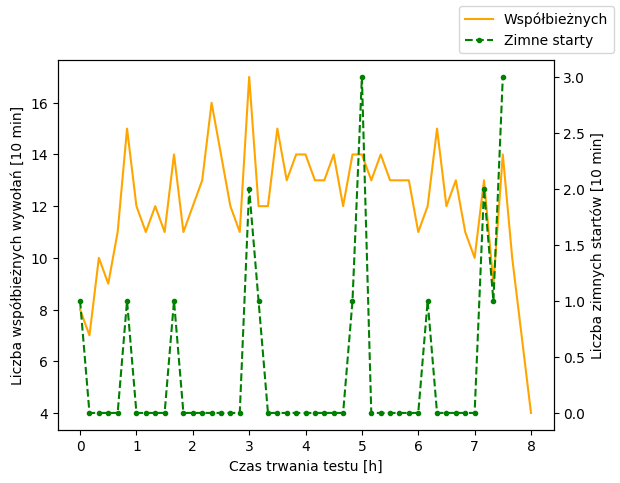

In [73]:
fig, ax = start_plot()
# ax.plot(human_delta(resampled_invocations.index), resampled_invocations['invocations'], label="Łącznie")
ax.plot(human_delta(resampled_concurrent.index), resampled_concurrent['concurrentExecutions'], label="Współbieżnych", color='orange')
ax.set_ylabel("Liczba współbieżnych wywołań [10 min]")

ax2 = ax.twinx()
ax2.plot(human_delta(cold_starts.index), cold_starts['duration'], color='green', marker='.', linestyle='--', label='Zimne starty')
ax2.set_ylabel("Liczba zimnych startów [10 min]")
fig.legend()

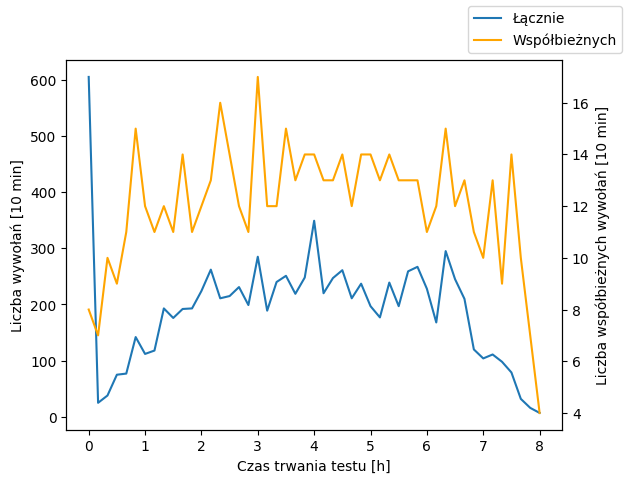

In [71]:
fig, ax = start_plot()
ax.plot(human_delta(resampled_invocations.index), resampled_invocations['invocations'], label="Łącznie")
ax.set_ylabel("Liczba wywołań [10 min]")

ax2 = ax.twinx()
ax2.plot(human_delta(resampled_concurrent.index), resampled_concurrent['concurrentExecutions'], label="Współbieżnych", color='orange')
ax2.set_ylabel("Liczba współbieżnych wywołań [10 min]")
fig.legend()

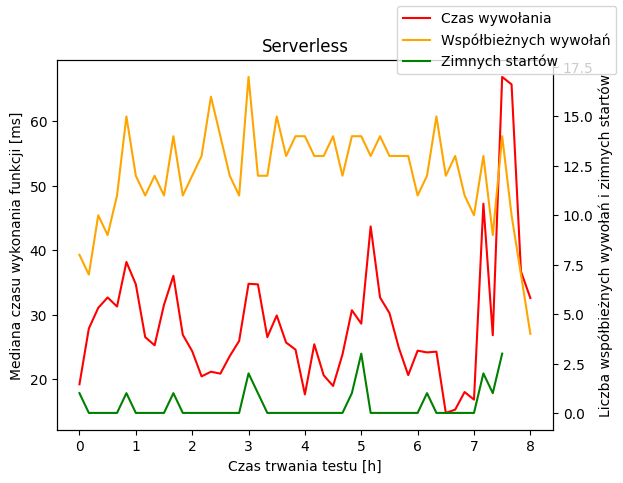

In [92]:

# TODO: zestawić czas trwania żądania z liczbą (jednoczesnych) wywołań lambd

fig, ax = start_plot()

logs_resampled = logs.resample('10T').median(numeric_only=True)

ax.plot(human_delta(logs_resampled.index), logs_resampled['duration'], label="Czas wywołania", color='red')
ax2 = ax.twinx()
ax2.plot(human_delta(resampled_concurrent.index), resampled_concurrent['concurrentExecutions'], label="Współbieżnych wywołań", color='orange')
ax2.set_ylabel('Liczba współbieżnych wywołań i zimnych startów')
ax2.plot(human_delta(cold_starts.index), cold_starts['duration'], color='green', label='Zimnych startów')
ax.set_ylabel('Mediana czasu wykonania funkcji [ms]')
ax.set_title('Serverless')
fig.legend()


# CZAS WYKONANIA FUNKCJI! A nie czas odpowiedzi, API Gateway dodaje +100 latency, co najmniej.
# Byśmy musieli mieć raw data from EC2 żeby to porównywać load testowo, a nie mamy.
# No możemy niby mieć...

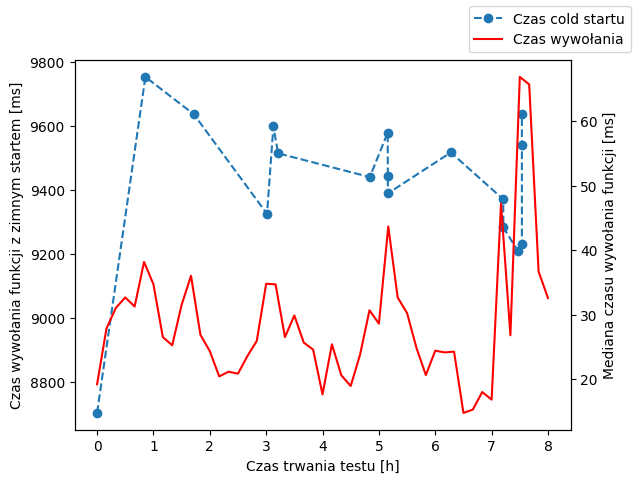

In [104]:
fig, ax = start_plot()

only_cold_start = logs[logs['initDuration'] > 0]

ax.plot(human_delta(only_cold_start.index), only_cold_start['duration'], label="Czas zimnego startu", marker='o', linestyle='--')
ax2 = ax.twinx()
ax2.plot(human_delta(logs_resampled.index), logs_resampled['duration'], label="Czas wywołania", color='red')
ax.set_ylabel("Czas wywołania funkcji z zimnym startem [ms]")
ax2.set_ylabel("Mediana czasu wywołania funkcji [ms]")
fig.legend()
#TODO: cold start chart (scatter, time vs cold start time)
#TODO: aurora utilization chart
#TODO: aurora connections chart